In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ssm

from data_processing import *
from pca_analysis import *
%load_ext autoreload
%autoreload 2
np.random.seed(42)

In [2]:
alldat = load_data()

In [3]:
print(alldat[25]['spks'].shape)

(1056, 178, 250)


In [6]:
dt = 0.01 # bin duration (ms)
t = np.arange(250)*dt
t -= 0.5 # set timestep 0 to stimulus onset 

In [7]:
def print_trial_outcome(dat, trial_idx):
    print(trial_idx)
    print(dat['response'][trial_idx])
    if dat['contrast_left'][trial_idx] != 0 and dat['contrast_right'][trial_idx] != 0:
        stimulus = "Both left: {}%, right: {}%".format(dat['contrast_left'][trial_idx]*100, 100*dat['contrast_right'][trial_idx]) 
    elif dat['contrast_left'][trial_idx] != 0.0:
        stimulus = "Left {}%".format(dat['contrast_left'][trial_idx]*100)
    elif dat['contrast_right'][trial_idx] != 0.0:
        stimulus = "Right {}%".format(dat['contrast_right'][trial_idx]*100)
    else:
        stimulus = "Neither"
    
    response = ["Right", "NoGo", "Left"][int(dat['response'][trial_idx]+1)]
    
    feedback = "Reward" if dat['feedback_type'][trial_idx] == 1 else "White noise"
    
    print("-------- Trial number {} --------".format(trial_idx))
    print("Stimulus:", stimulus)
    print("Response:", response)
    print("Feedback:", feedback)
    

def plot_vlines(dat, trial_idx, label=False):
    print(dat['gocue'][trial_idx,0])
#     plt.axvline(0, color="black", linestyle=":", label="Stim onset" if label else "")
    plt.axvline(dat['gocue'][trial_idx,0], color="black", linestyle="--", label="Go cue" if label else "")
    plt.axvline(dat['feedback_time'][trial_idx,0], color="black", linestyle="-", label="Feedback" if label else "")
#     plt.axvline(dat['response_time'][trial_idx,0], color="tab:orange", linestyle="--", label="Response" if label else "")
    

In [8]:
def train_hmm(session, brain_area, n_states, start=0, stop=250, n_iters=100, passive=False):
    dat = alldat[session]

    if not passive:
        # take active trials
        spks = dat['spks'][dat['brain_area'] == brain_area]
        spks = spks[:,:,start:stop]
    else:
        # take passive trials
        spks = dat['spks_passive'][dat['brain_area'] == brain_area]
        
        passive_trials = (np.abs(dat['wheel_passive'][0]) < 2).all(axis=1)
        passive_spks = spks[:,passive_trials]
        print(np.count_nonzero(passive_trials))
        spks = passive_spks[:,:,start:stop]
    
    data= np.transpose(spks, (1,2,0)) # n_trials x n_timesteps x n_neurons

    # train/test split
    train_data, test_data, rdm_idx = data_split(data, int(0.8*len(data)))
    mean_spike_counts = train_data.mean(axis=(0,1))
    train_data = list(train_data)
    test_data = list(test_data)

    n_neurons = train_data[0].shape[1]
    
    # create the hmm
    hmm = ssm.HMM(n_states, n_neurons, observations="poisson", transitions="standard")

    # initialization
    init_lambdas = np.random.uniform(low=np.zeros_like(mean_spike_counts),
                                     high=mean_spike_counts, size=(n_states,n_neurons)) # n_states x n_neurons
    hmm.log_lambdas = np.log(init_lambdas + 1e-16)
    
    lls = hmm.fit(list(train_data), method='em', num_iters=n_iters)
    
    return hmm, lls, dat, rdm_idx, train_data, test_data


def viz_hmm(res):
    hmm, lls, dat, rdm_idx, train_data, test_data = res    
    
    print("Train ll:", lls[-1])
    test_ll = hmm.log_likelihood(list(test_data))
    print("Test ll:", test_ll)
    plt.plot(lls)
    plt.title("Log likelihood")
    plt.show()
    
    
    learned_transition_mat = hmm.transitions.transition_matrix

    fig = plt.figure(figsize=(8, 4))
    im = plt.imshow(learned_transition_mat)
    plt.title("Learned transition matrix")

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    fig = plt.figure(figsize=(8, 8))
    for i, log_lambda in enumerate(hmm.observations.log_lambdas):
        plt.subplot(len(hmm.observations.log_lambdas), 1, i+1)
        plt.title("Latent state {}".format(i))
        plt.bar(np.arange(len(log_lambda)), np.exp(log_lambda))
        print(np.argmax(log_lambda))
    plt.tight_layout()
    plt.show()


In [23]:
def plot_posterior(res, n_trials=10, plot_wheel=False, plot_face=False, plot_pupil=False, test=False, passive=False):
    hmm, lls, dat, rdm_idx, train_data, test_data = res

    dt = 0.01 # bin duration (ms)
    t = np.arange(train_data[0].shape[0])*dt
    t -= 0.5 # set timestep 0 to stimulus onset 
    print(len(train_data), len(test_data), rdm_idx.shape)
    for i in range(n_trials):
        if test:
            trial_spikes = test_data[i]
            trial_idx = rdm_idx[len(train_data)+i]
        else:
            trial_spikes = train_data[i]
            trial_idx = rdm_idx[i]
        print(trial_idx)
        
        if not passive:
            print_trial_outcome(dat, trial_idx)
        posterior = hmm.filter(trial_spikes)
        n_states = posterior.shape[1]

        # plot posterior of states for a single test trial
        fig = plt.figure(figsize=(7, 6))
        plt.title("Posterior distribution of the latent state")
        ax1 = plt.subplot(2, 1, 1)
        
        colors = ["cornflowerblue", "orange", "yellowgreen", "firebrick"]
        for i in range(posterior.shape[1]):
            plt.plot(t, posterior[:,i], label="State %d" % i, color=colors[i])

            
            if trial_idx == 148:
                plt.text(0.15, -0.12, "state on", va='top', ha='center', color="dimgrey")
                plt.text(0.55, -0.12, "mov on", va='top', ha='center', color="dimgrey")
    
                plt.axvline(0.15, linestyle="--", color="dimgrey")
                plt.axvline(0.55, linestyle="--", color="dimgrey")
                
#         if not passive:
# #             plt.axvline(0, color="black", linestyle="--")
# #             plt.axvline(dat['gocue'][trial_idx,0], color="black", linestyle=":")
# #             plt.axvline(dat['feedback_time'][trial_idx,0], color="black", linestyle="-", label="Feedback")
            
        plt.legend()
        plt.ylabel("Probability")
        
        if plot_wheel:
            ax2 = plt.subplot(2, 1, 2, sharex=ax1)
            
            if trial_idx == 148:
                plt.axvline(0.15, linestyle="--", color="black")
                plt.axvline(0.55, linestyle="--", color="black")

            if not passive:
                plt.plot(t, np.cumsum(dat['wheel'][0,trial_idx]), color="gray")
#                 plt.axvline(0, color="black", linestyle="--")
#                 plt.axvline(dat['gocue'][trial_idx,0], color="black", linestyle=":")
    #             plt.axvline(dat['feedback_time'][trial_idx,0], color="black", linestyle="-", label="Feedback")
#                 plt.plot(t, dat['wheel'][0,trial_idx])
            else:
                plt.plot(t, np.cumsum(dat['wheel_passive'][0,trial_idx]), color="gray")

            plt.xlabel("Time (s)")
            plt.ylabel("Wheel position")
            plt.setp(ax1.get_xticklabels(), visible=False)
            plt.show()
        else:
            
            plt.xlabel("Time (s)")
            plt.legend()
            plt.show()

            
def plot_hidden_states(res):
    hmm, lls, dat, rdm_idx, train_data, test_data = res    

    colors = ["cornflowerblue", "orange", "yellowgreen", "firebrick"]
    fig = plt.figure(figsize=(3, 6))
    for i, log_lambda in enumerate(hmm.observations.log_lambdas):
        print(np.argsort(log_lambda)[-2:])
        
        
        plt.subplot(len(hmm.observations.log_lambdas), 1, i+1)
        plt.title("Latent state {}".format(i))
        plt.bar(np.arange(len(log_lambda)), np.exp(log_lambda), color=colors[i])
        plt.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.tight_layout()
    plt.show()

## Whole trial

In [10]:
session = 25
brain_area = "MOs"
n_states = 4

res_mos_active = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

142 36 (178,)
134
134
1.0
-------- Trial number 134 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


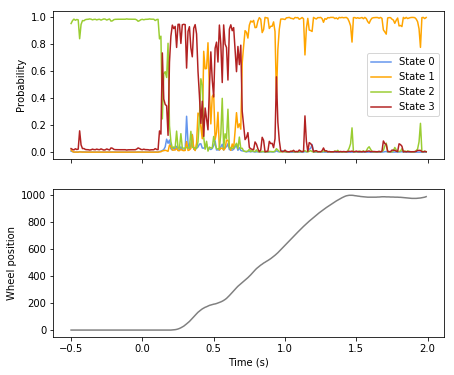

148
148
1.0
-------- Trial number 148 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


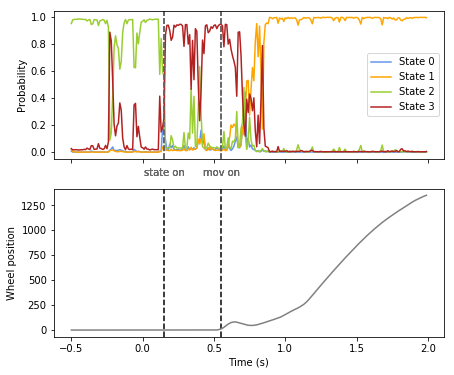

163
163
0.0
-------- Trial number 163 --------
Stimulus: Left 100.0%
Response: NoGo
Feedback: White noise


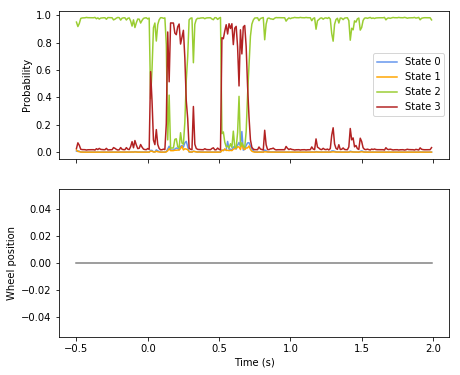

63
63
-1.0
-------- Trial number 63 --------
Stimulus: Neither
Response: Right
Feedback: White noise


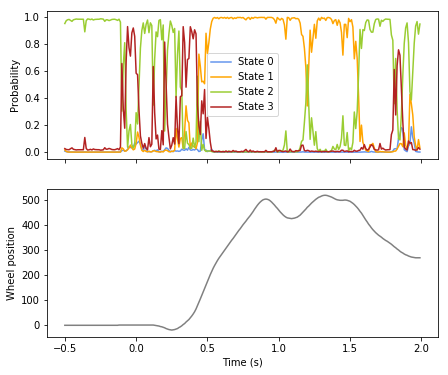

54
54
1.0
-------- Trial number 54 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


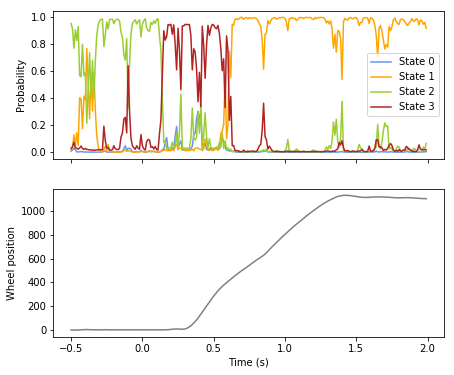

107
107
1.0
-------- Trial number 107 --------
Stimulus: Both left: 25.0%, right: 50.0%
Response: Left
Feedback: White noise


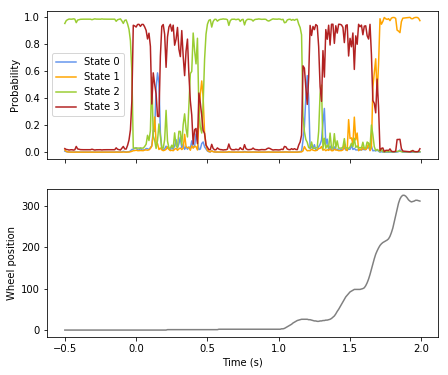

50
50
0.0
-------- Trial number 50 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


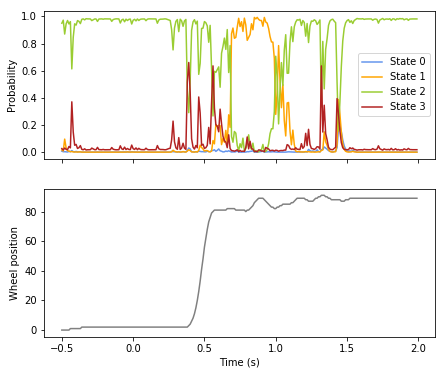

175
175
0.0
-------- Trial number 175 --------
Stimulus: Left 100.0%
Response: NoGo
Feedback: White noise


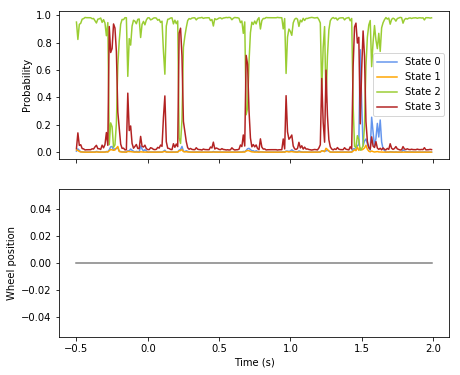

58
58
-1.0
-------- Trial number 58 --------
Stimulus: Neither
Response: Right
Feedback: White noise


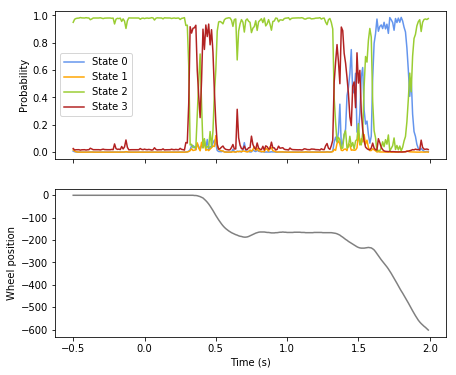

48
48
1.0
-------- Trial number 48 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


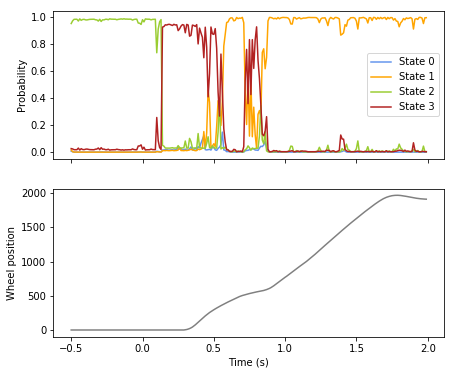

88
88
-1.0
-------- Trial number 88 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


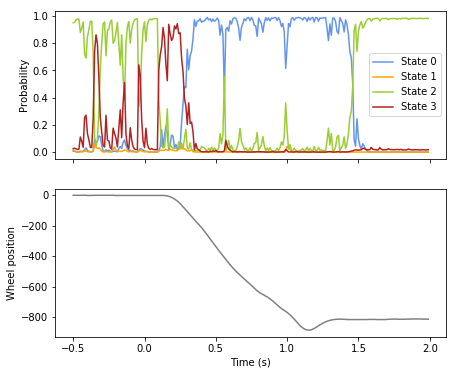

21
21
1.0
-------- Trial number 21 --------
Stimulus: Both left: 100.0%, right: 25.0%
Response: Left
Feedback: Reward


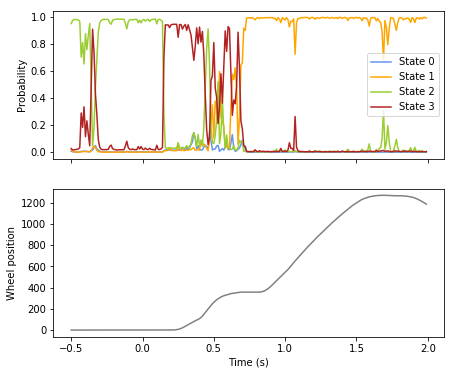

57
57
-1.0
-------- Trial number 57 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


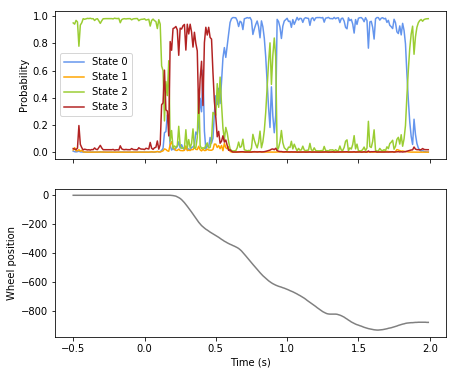

172
172
0.0
-------- Trial number 172 --------
Stimulus: Left 100.0%
Response: NoGo
Feedback: White noise


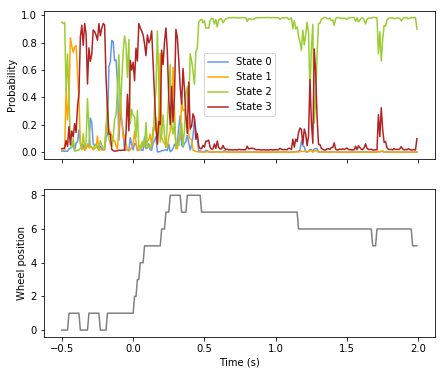

129
129
-1.0
-------- Trial number 129 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


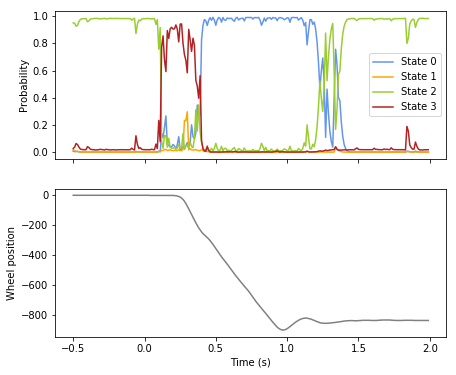

37
37
1.0
-------- Trial number 37 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


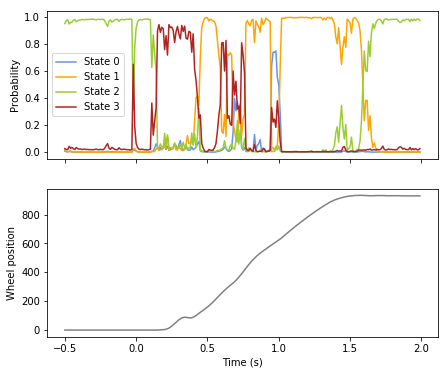

157
157
-1.0
-------- Trial number 157 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


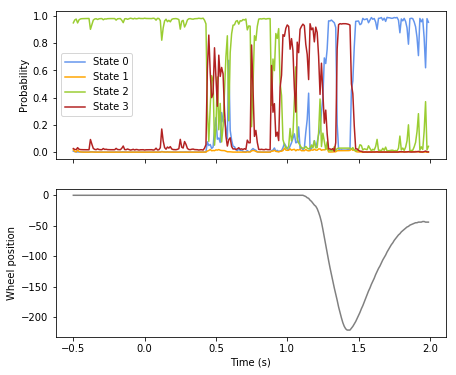

168
168
0.0
-------- Trial number 168 --------
Stimulus: Left 100.0%
Response: NoGo
Feedback: White noise


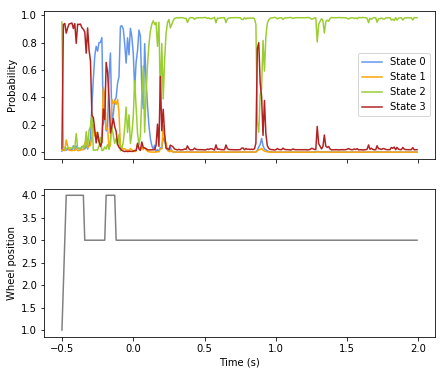

1
1
1.0
-------- Trial number 1 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


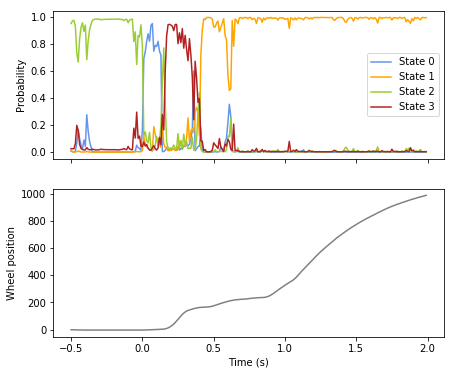

52
52
-1.0
-------- Trial number 52 --------
Stimulus: Both left: 25.0%, right: 50.0%
Response: Right
Feedback: Reward


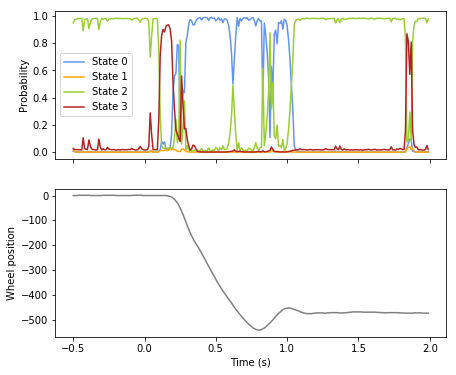

In [26]:
plot_posterior(res_mos_active, n_trials=20, plot_wheel=True, test=True)

In [12]:
def plot_intervals(res, mvt_direction="", test=False, color=""):
    hmm, lls, dat, rdm_idx, train_data, test_data = res    
    
    data = train_data if not test else test_data
    
    occs = []
    mvts = []
    for i, spks in enumerate(data):
        trial_idx = rdm_idx[i] if not test else rdm_idx[len(train_data)+i]
        ml_states = hmm.most_likely_states(spks)

        mvt_threshold = 3
        prestim = 40
    
        if mvt_direction == "left":
            occ = np.argwhere(ml_states == 1)
            mvt = np.argwhere(dat['wheel'][0,trial_idx] >  mvt_threshold)
        elif mvt_direction == "right":
            occ = np.argwhere(ml_states == 0)
            mvt = np.argwhere(dat['wheel'][0,trial_idx] <  -mvt_threshold)
        else:
            occ = np.argwhere(ml_states == 3)
            mvt = np.argwhere(np.abs(dat['wheel'][0,trial_idx]) >  mvt_threshold)
        
        occ = occ[occ > prestim] # after the prestim activity        
        mvt = mvt[mvt > prestim]

        if len(mvt) > 0 and len(occ) > 0:
            first_occ = occ[0]
            occs.append(first_occ)
            first_mvt = mvt[0]
            mvts.append(first_mvt)
#         elif len(mvt) > 0:
#             print("Movement and no red states in trial", trial_idx)
#             print(np.array(mvt)*0.01 - 0.5)
     
    intervals = np.array(occs) - np.array(mvts)
#     plt.hist(intervals*0.01,18, (-1.5, 1.5), label="Train data" if not test else "Test data", alpha=0.5, color=color if color else "tab:blue")
    plt.hist(intervals*0.01,18, (-1.5, 1.5), alpha=.9, color=color if color else "tab:blue")
    plt.xlabel("Time interval (s)")
    plt.ylabel("Number of trials")
#     plt.legend()
    

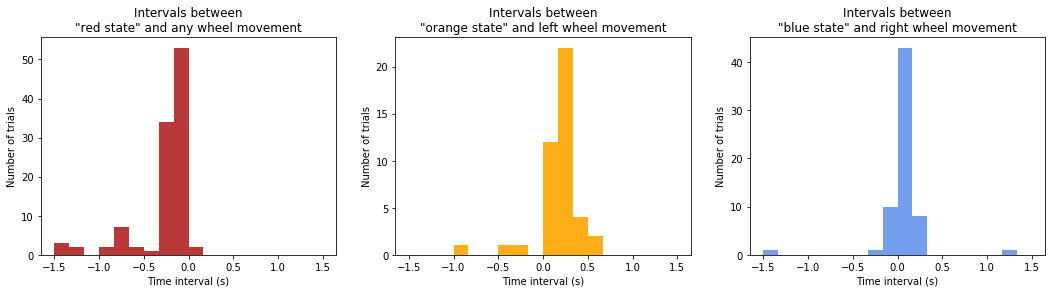

In [13]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.title('Intervals between\n"red state" and any wheel movement')
plot_intervals(res_mos_active, test=False, color="firebrick")
# plot_intervals(res_mos_active, test=True, color="black")

plt.subplot(1, 3, 2)
plt.title('Intervals between\n"orange state" and left wheel movement')
plot_intervals(res_mos_active, test=False, mvt_direction="left", color="orange")
# plot_intervals(res_mos_active, test=True, mvt_direction="left", color="black")

plt.subplot(1, 3, 3)
plt.title('Intervals between\n"blue state" and right wheel movement')
plot_intervals(res_mos_active, test=False, mvt_direction="right", color="cornflowerblue")
# plot_intervals(res_mos_active, test=True, mvt_direction="right", color="black")
# plt.tight_layout()
# plt.suptitle("Intervals between first state onset and first wheel movement onset in each trial", size=14)
# plt.subplots_adjust(top=0.84) 

# plt.savefig("figures/intervals_state_movement")

plt.show()

[64 57]
[ 87 161]
[105  38]
[120  71]


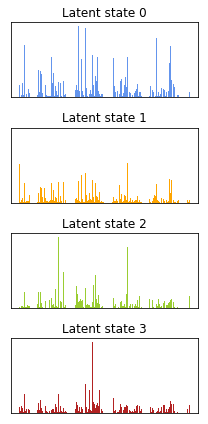

In [24]:
plot_hidden_states(res_mos_active)

In [15]:
session = 25
brain_area = "MOs"
dat = alldat[session]
spks_data = alldat[session]['spks'][dat['brain_area'] == brain_area]
proj_data, expl_var, pc = single_trial_pc(spks_data, n_components=1)
print(expl_var)
print(proj_data.shape)

right_data = proj_data[alldat[session]['response'] == -1][:,:,0]
left_data = proj_data[alldat[session]['response'] == 1][:,:,0]

# print(right_data.shape, left_data.shape)

# for i in range(1):
#     plt.plot(right_data[i,:,0], right_data[i,:,1], ".-", alpha=.5, color="tab:blue")
#     plt.plot(left_data[i,:,0], left_data[i,:,1], ".-", alpha=.5, color="tab:orange")
# plt.show()

[0.35813075]
(178, 250, 1)


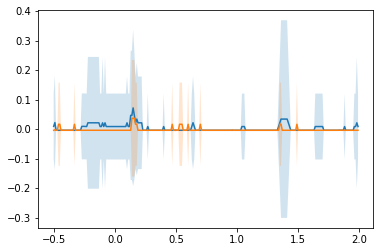

In [16]:
plt.plot(t, right_data.mean(0), label="Right")
plt.fill_between(t,right_data.mean(0)-right_data.std(0),right_data.mean(0)+right_data.std(0),alpha=.2)

plt.plot(t, left_data.mean(0), label="Left")
plt.fill_between(t,left_data.mean(0)-left_data.std(0),left_data.mean(0)+left_data.std(0),alpha=.2)
    

### VISp

In [20]:
session = 11
brain_area = "VISp"
n_states = 3

res_visp = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

272 68 (340,)
284
284
1.0
-------- Trial number 284 --------
Stimulus: Both left: 50.0%, right: 25.0%
Response: Left
Feedback: Reward


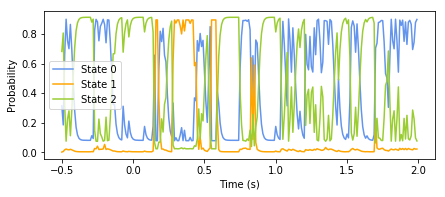

116
116
0.0
-------- Trial number 116 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


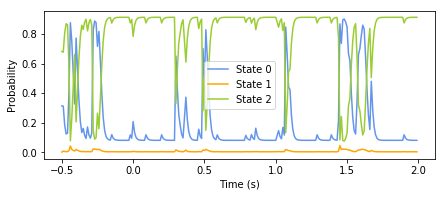

113
113
1.0
-------- Trial number 113 --------
Stimulus: Neither
Response: Left
Feedback: White noise


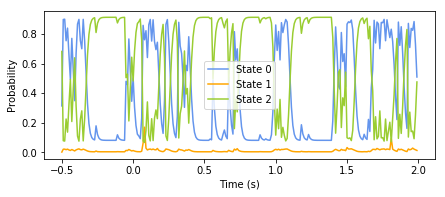

42
42
1.0
-------- Trial number 42 --------
Stimulus: Left 25.0%
Response: Left
Feedback: Reward


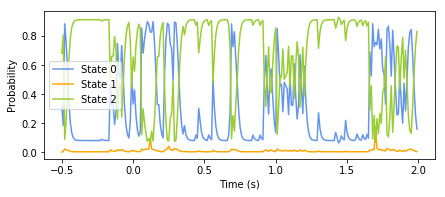

126
126
1.0
-------- Trial number 126 --------
Stimulus: Neither
Response: Left
Feedback: White noise


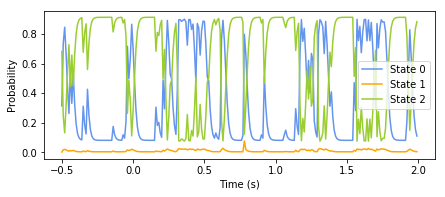

231
231
1.0
-------- Trial number 231 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


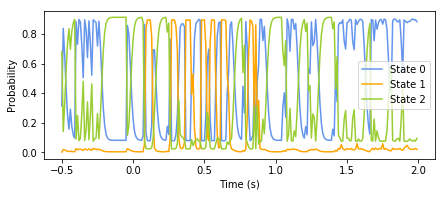

181
181
-1.0
-------- Trial number 181 --------
Stimulus: Neither
Response: Right
Feedback: White noise


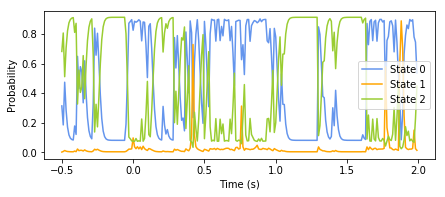

278
278
-1.0
-------- Trial number 278 --------
Stimulus: Right 25.0%
Response: Right
Feedback: Reward


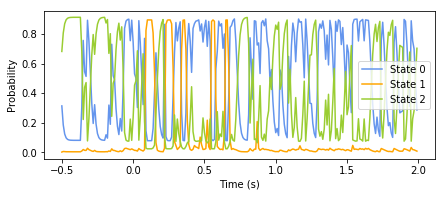

337
337
0.0
-------- Trial number 337 --------
Stimulus: Right 100.0%
Response: NoGo
Feedback: White noise


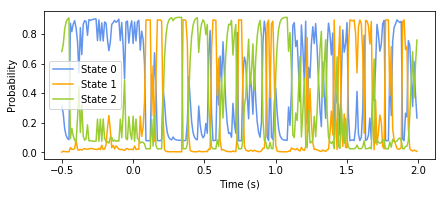

25
25
0.0
-------- Trial number 25 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


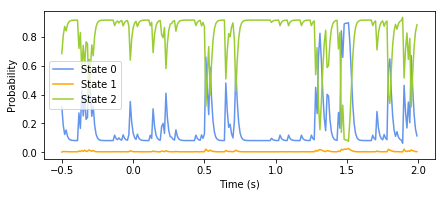

124
124
0.0
-------- Trial number 124 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


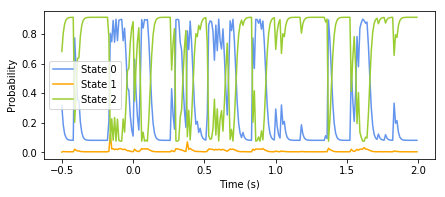

221
221
0.0
-------- Trial number 221 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


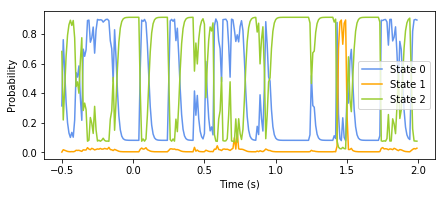

261
261
-1.0
-------- Trial number 261 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


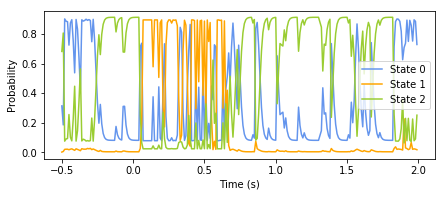

155
155
1.0
-------- Trial number 155 --------
Stimulus: Both left: 100.0%, right: 25.0%
Response: Left
Feedback: Reward


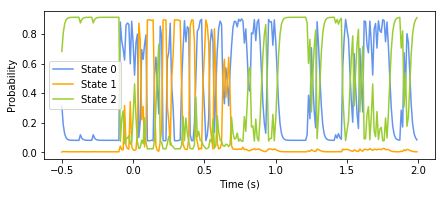

109
109
1.0
-------- Trial number 109 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


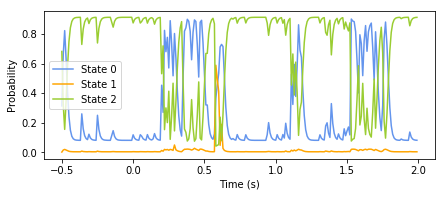

172
172
-1.0
-------- Trial number 172 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


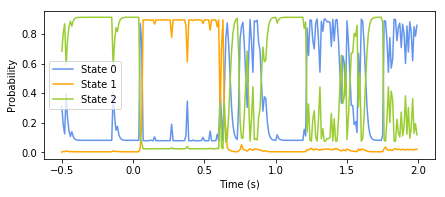

118
118
-1.0
-------- Trial number 118 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


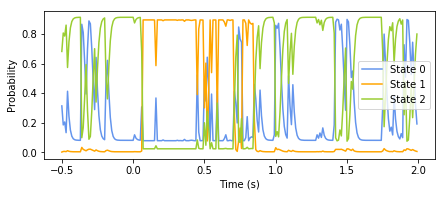

325
325
1.0
-------- Trial number 325 --------
Stimulus: Both left: 100.0%, right: 25.0%
Response: Left
Feedback: Reward


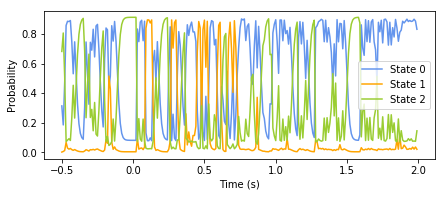

266
266
1.0
-------- Trial number 266 --------
Stimulus: Both left: 50.0%, right: 100.0%
Response: Left
Feedback: White noise


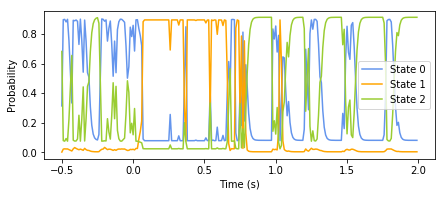

9
9
-1.0
-------- Trial number 9 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


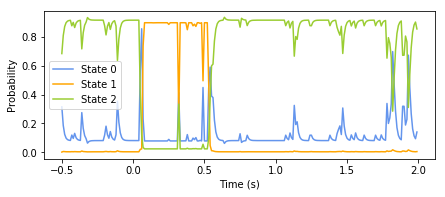

In [25]:
plot_posterior(res_visp, n_trials=20, plot_wheel=False, test=False)

### Trained on active, test on passive

How much variance is capture compared to hmm trained on passive trials ?
ll active passive = -220000, ll passive only = -120000

In [275]:
_, _, passive_dat, passive_rdm_idx, passive_train_data, passive_test_data = train_hmm(session, brain_area, n_states, start=0, stop=250, n_iters=0, passive=True)
active_hmm, active_lls, _, _, _, _ = res_mos_active

res_mos_active_passive = active_hmm, active_lls, passive_dat, passive_rdm_idx, passive_train_data, passive_test_data

80


HBox(children=(FloatProgress(value=1.0, bar_style='info', max=1.0), HTML(value='')))

Train ll: -220931.2172529424
Test ll: -37021.39765119455


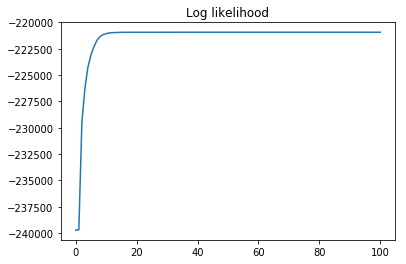

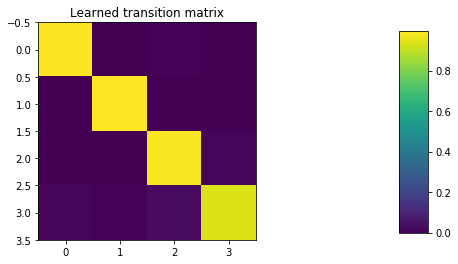

57
161
38
71


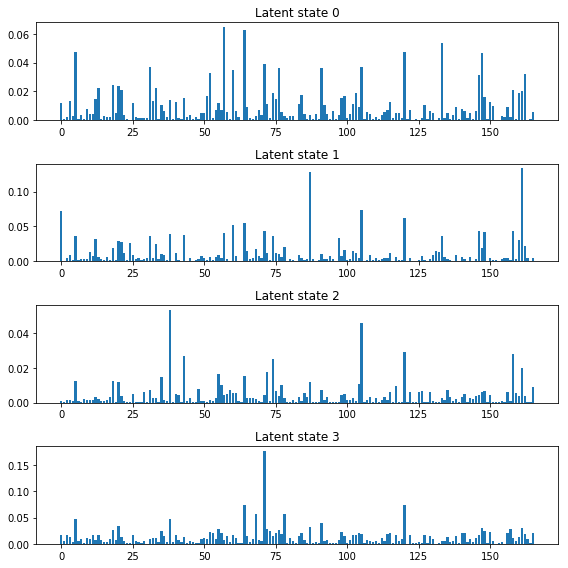

28
1.0
-------- Trial number 28 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


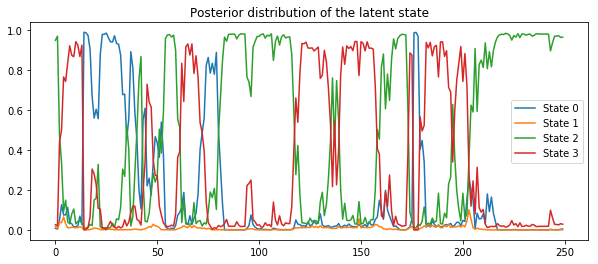

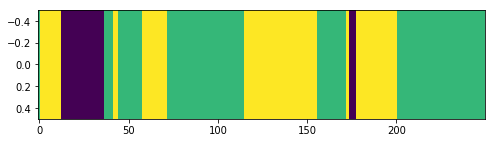

In [339]:
viz_hmm(res_mos_active_passive)

64 16 (80,)
30


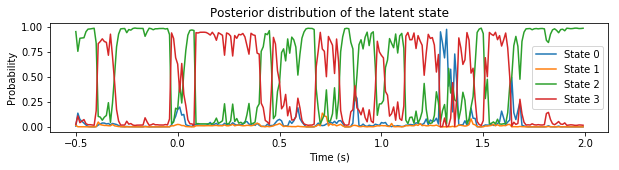

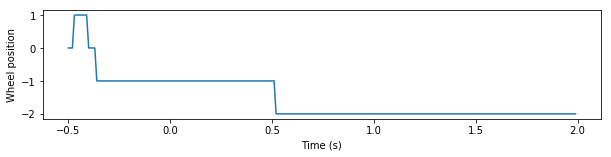

0


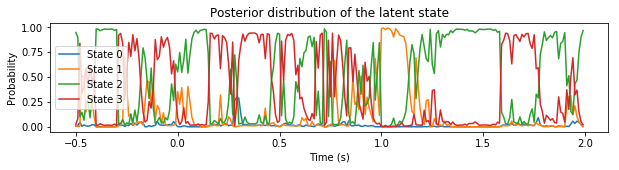

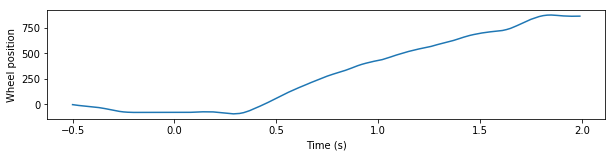

22


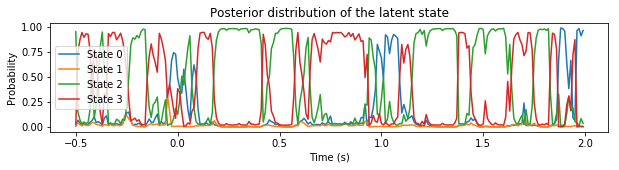

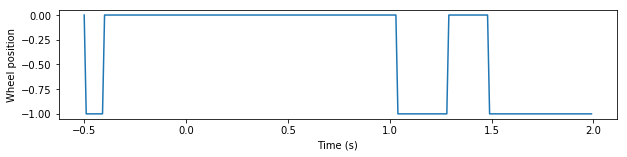

31


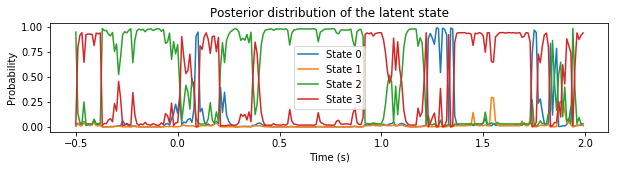

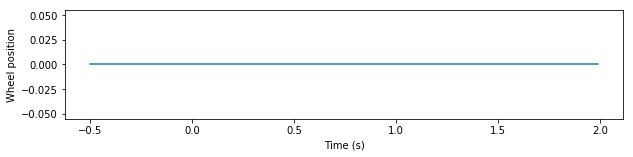

18


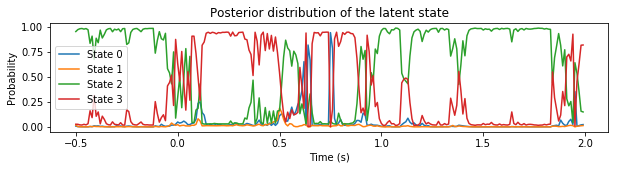

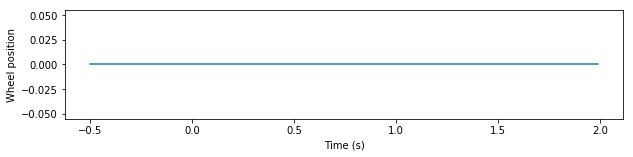

28


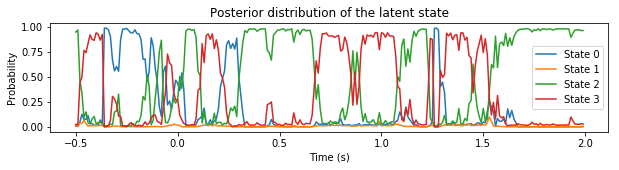

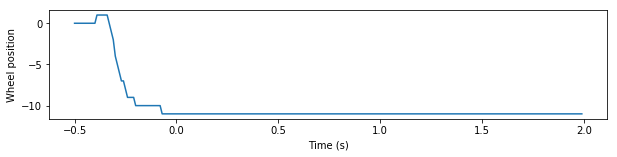

10


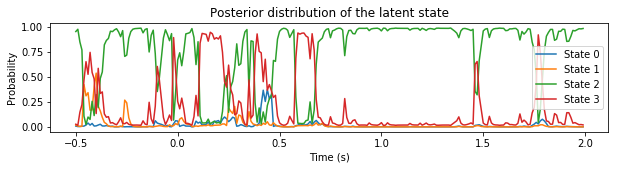

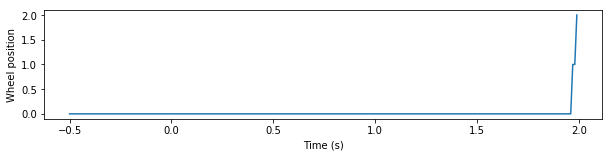

70


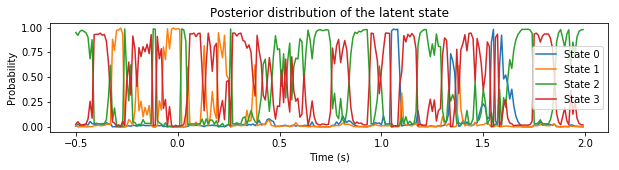

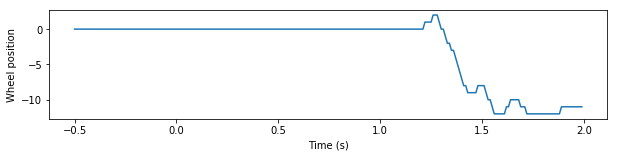

4


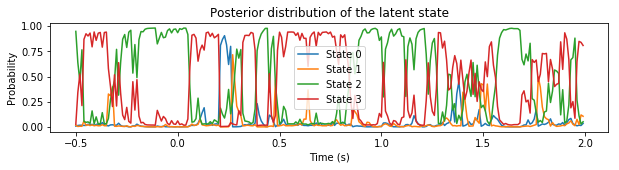

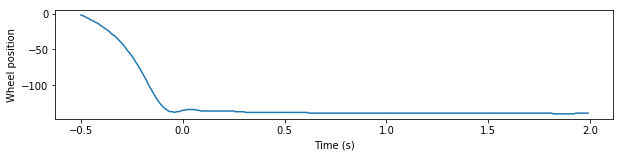

12


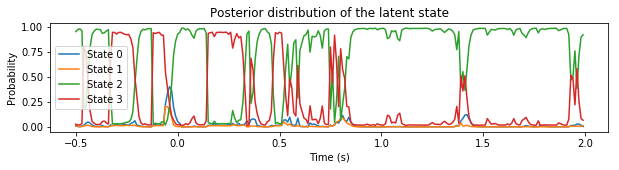

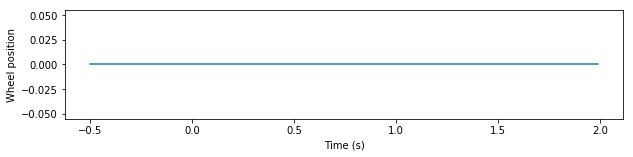

49


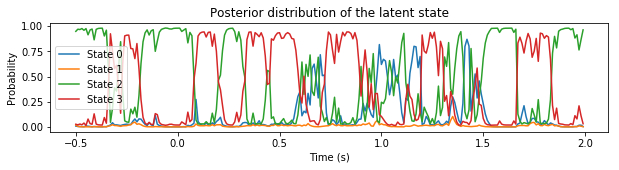

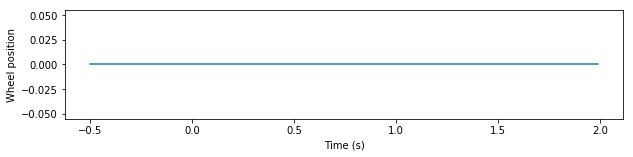

33


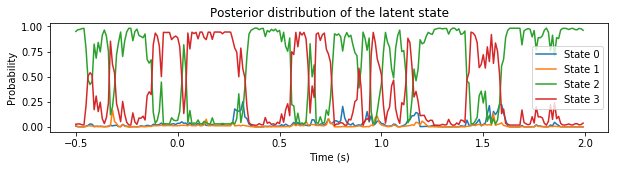

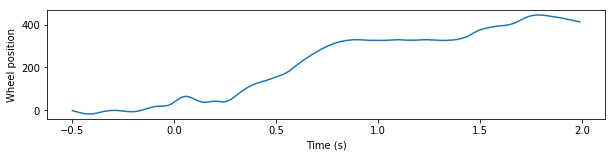

67


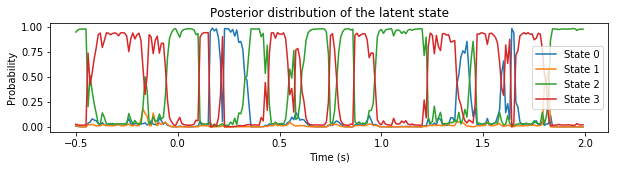

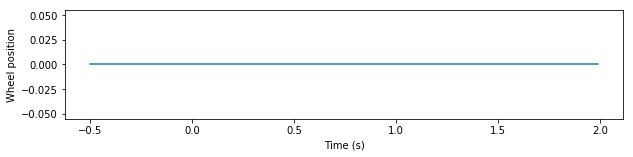

35


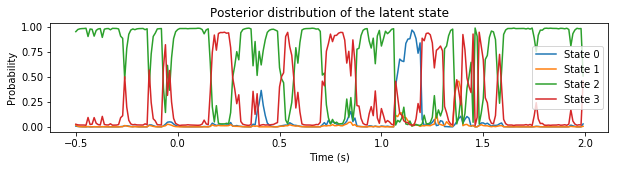

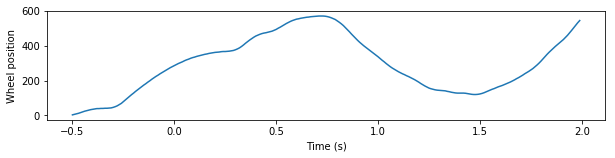

68


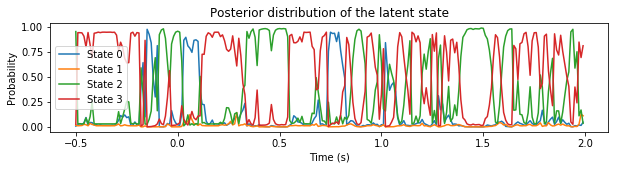

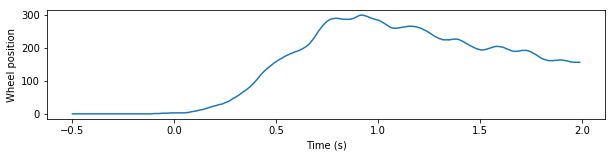

45


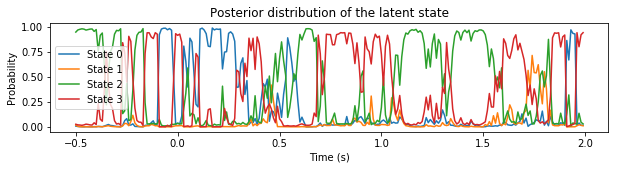

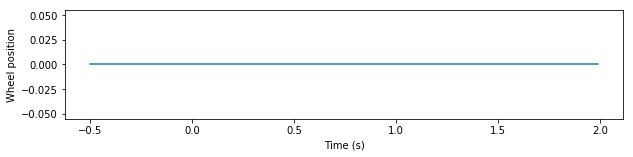

73


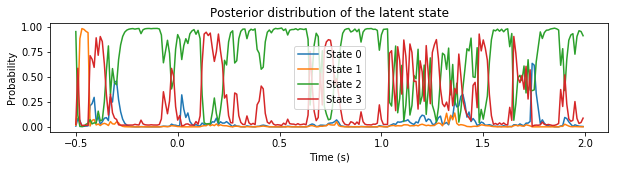

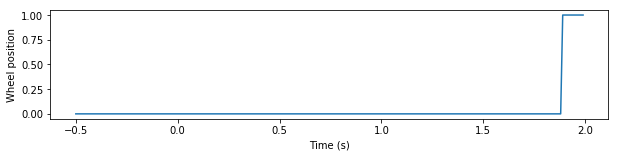

61


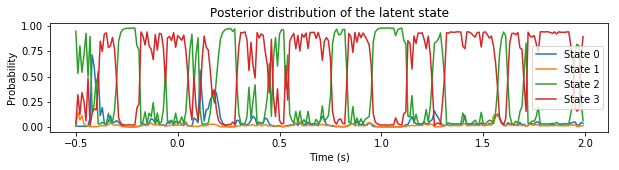

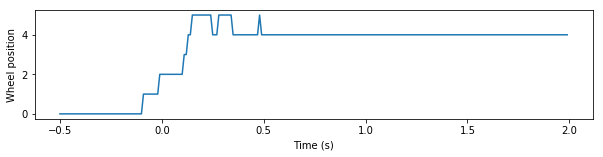

55


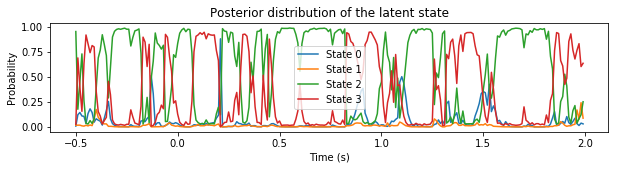

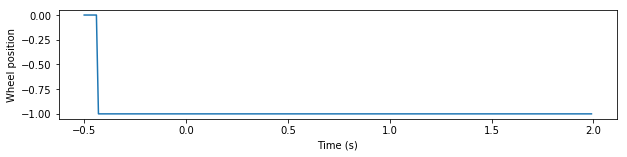

40


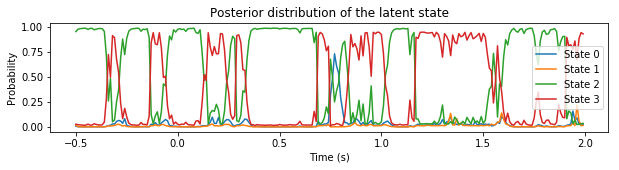

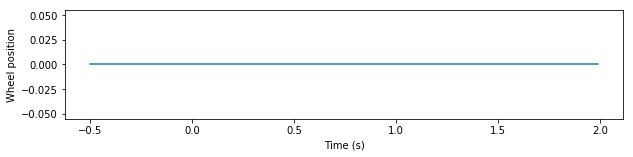

In [337]:
plot_posterior(res_mos_active_passive, n_trials=20, plot_wheel=True, passive=True)

## Prestim

In [29]:
session = 25
brain_area = "MOs"
n_states = 4

res_mos_25 = train_hmm(session, brain_area, n_states, start=0, stop=50)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

In [30]:
res_mos_bis = train_hmm(session, brain_area, n_states, start=0, stop=250, n_iters=0)
_, _, dat, rdm_idx, train_data, test_data = res_mos_bis

hmm, lls, _, _, _, _ = res_mos_25

res_mos = hmm, lls, dat, rdm_idx, train_data, test_data

HBox(children=(FloatProgress(value=1.0, bar_style='info', max=1.0), HTML(value='')))

-------- Trial number 19 --------
Stimulus: Neither
Response: Right
Feedback: White noise


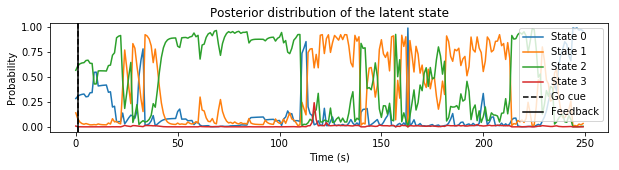

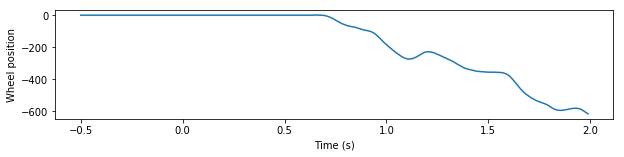

-------- Trial number 45 --------
Stimulus: Neither
Response: Left
Feedback: White noise


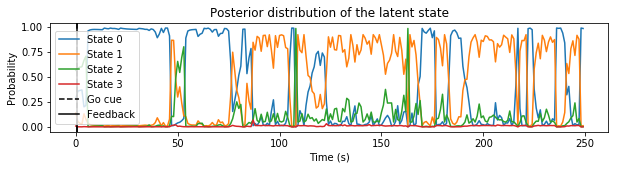

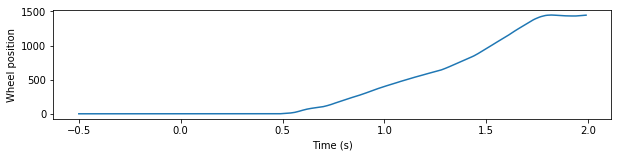

-------- Trial number 140 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


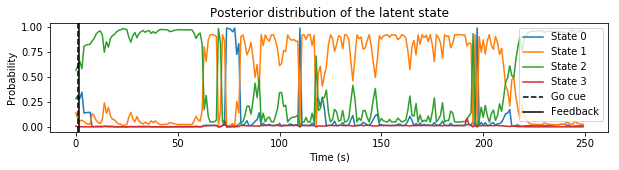

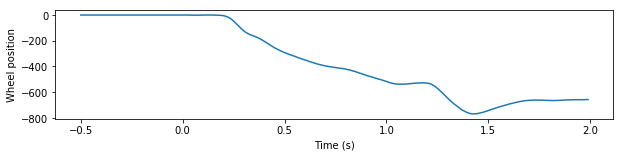

-------- Trial number 30 --------
Stimulus: Both left: 25.0%, right: 25.0%
Response: NoGo
Feedback: White noise


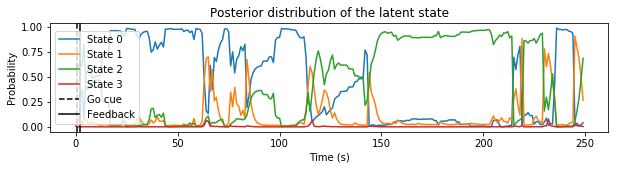

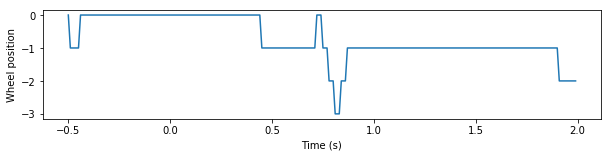

-------- Trial number 67 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


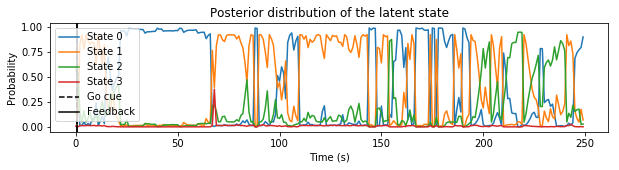

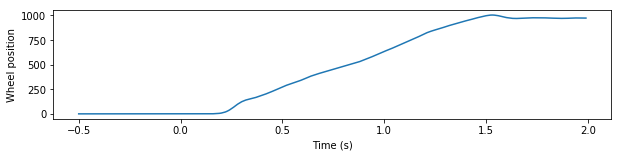

-------- Trial number 16 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Right
Feedback: Reward


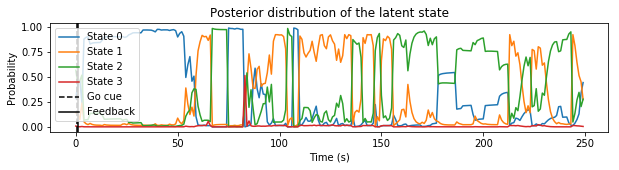

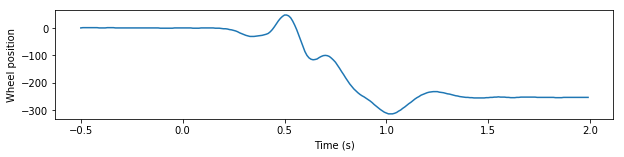

-------- Trial number 119 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


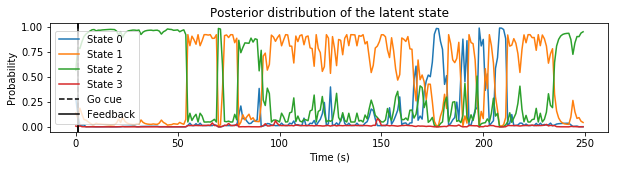

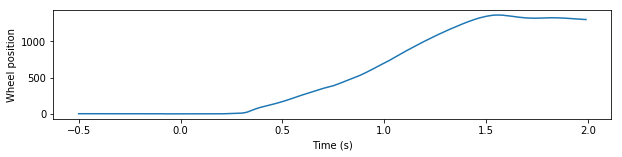

-------- Trial number 174 --------
Stimulus: Left 100.0%
Response: NoGo
Feedback: White noise


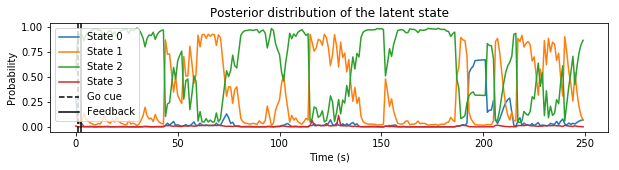

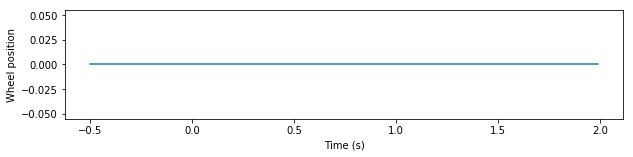

-------- Trial number 109 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


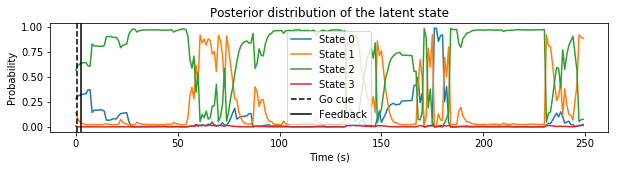

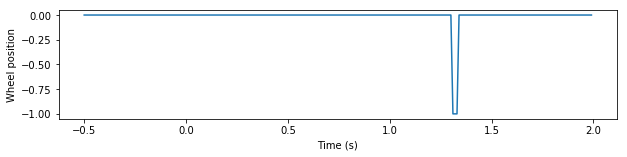

-------- Trial number 141 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


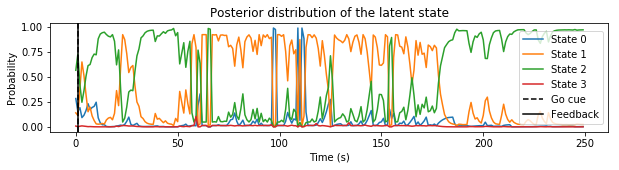

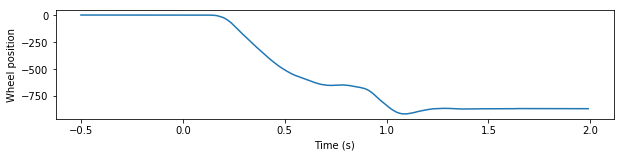

-------- Trial number 24 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


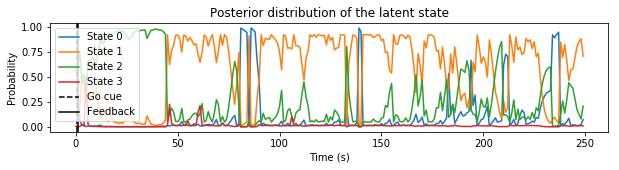

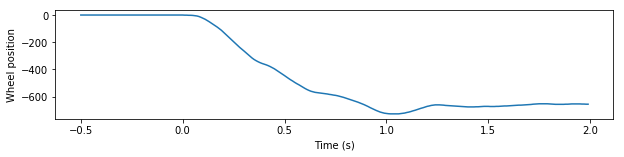

-------- Trial number 150 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


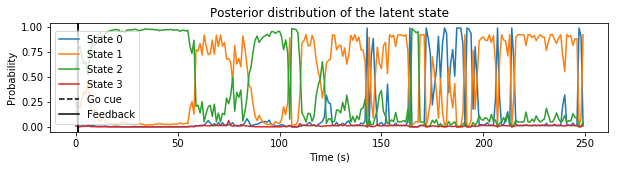

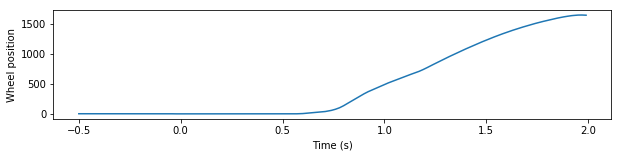

-------- Trial number 41 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


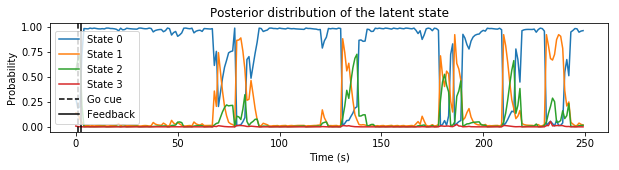

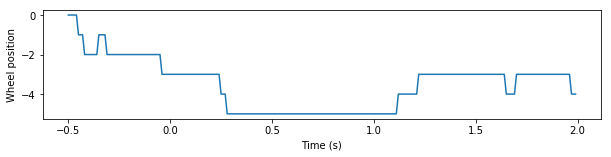

-------- Trial number 118 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


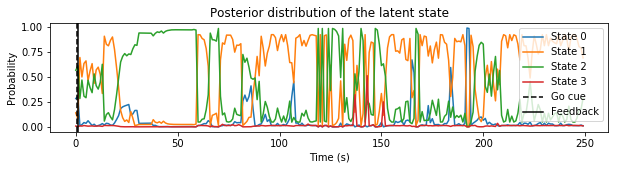

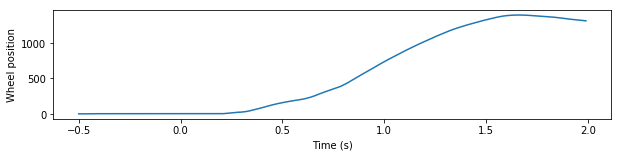

-------- Trial number 15 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


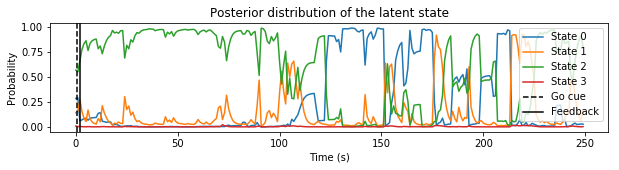

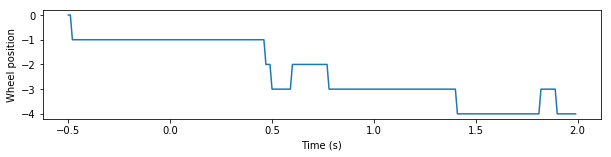

-------- Trial number 111 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


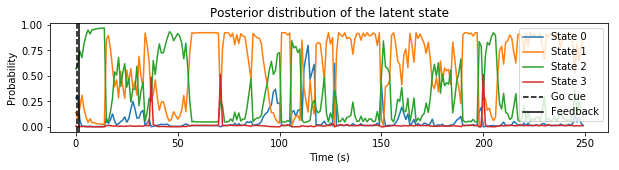

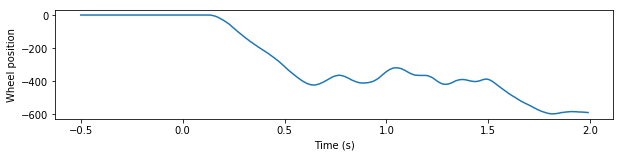

-------- Trial number 113 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


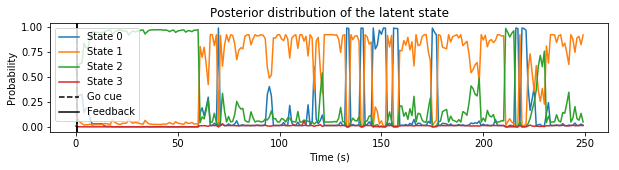

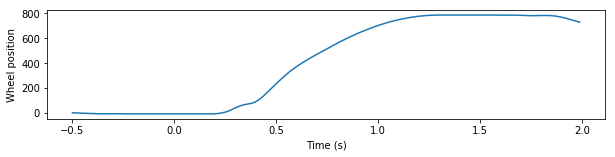

-------- Trial number 82 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


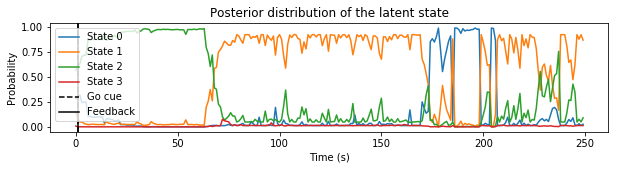

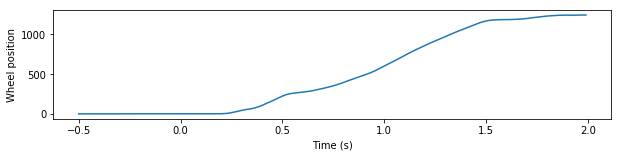

-------- Trial number 9 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


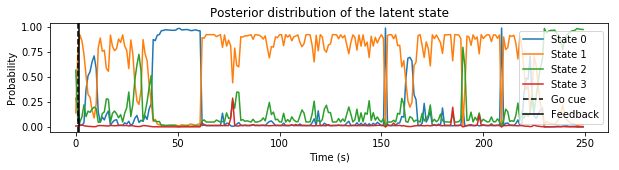

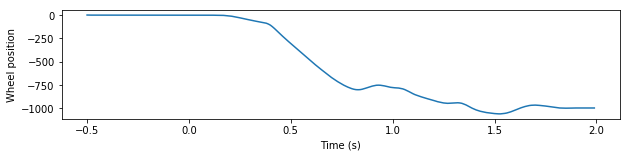

-------- Trial number 114 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


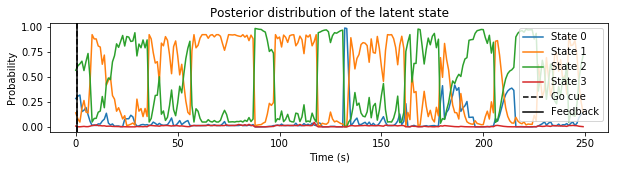

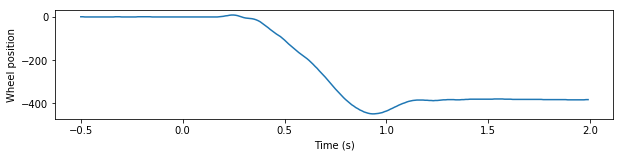

In [31]:
plot_posterior(res_mos, n_trials=20, plot_wheel=True)

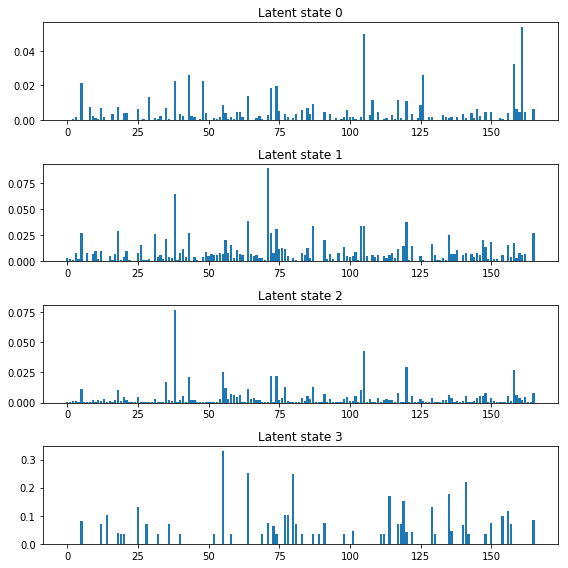

In [38]:
plot_hidden_states(res_mos_25)

## Passive

In [341]:
session = 25
brain_area = "MOs"
n_states = 4

res_mos_passive = train_hmm(session, brain_area, n_states, start=0, stop=250, passive=True)

80


HBox(children=(FloatProgress(value=0.0), HTML(value='')))

64 16 (80,)
30
30
0.0
-------- Trial number 30 --------
Stimulus: Both left: 25.0%, right: 25.0%
Response: NoGo
Feedback: White noise
0.6484104695918518


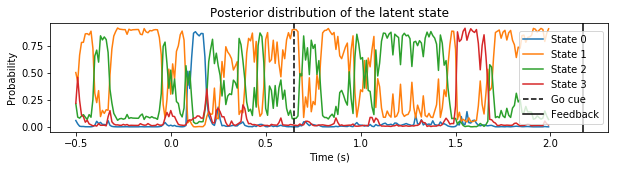

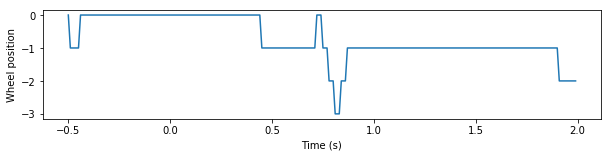

0
0
-1.0
-------- Trial number 0 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward
0.6480104630524295


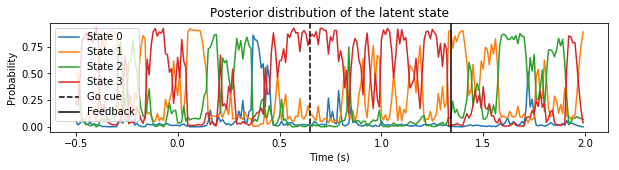

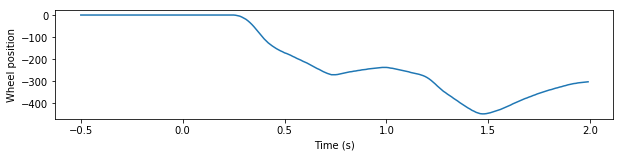

22
22
-1.0
-------- Trial number 22 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward
0.9620155964875607


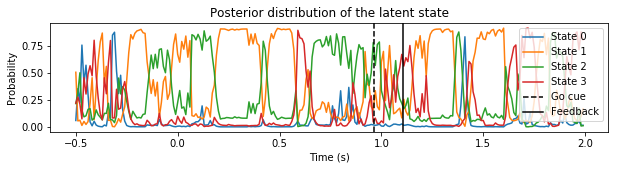

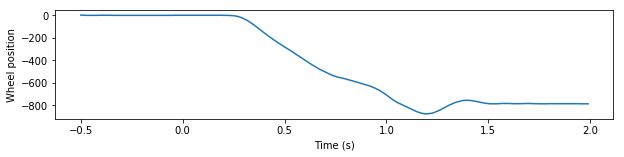

31
31
0.0
-------- Trial number 31 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward
0.5188083508237469


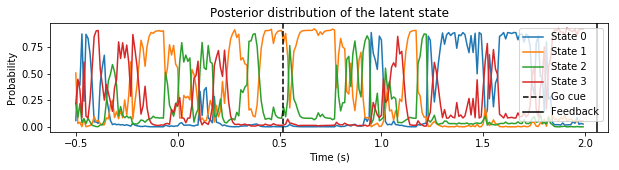

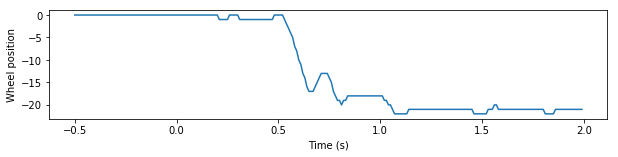

18
18
0.0
-------- Trial number 18 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward
0.7860127191481183


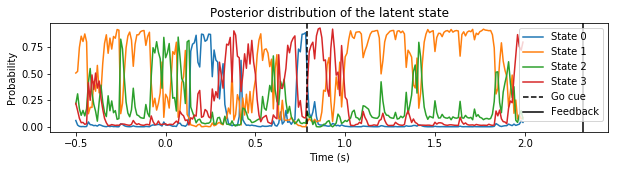

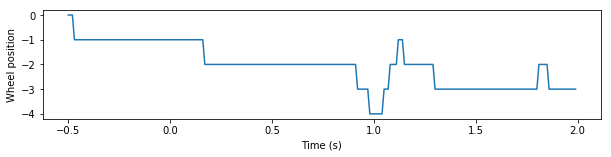

28
28
1.0
-------- Trial number 28 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward
0.5484088347399165


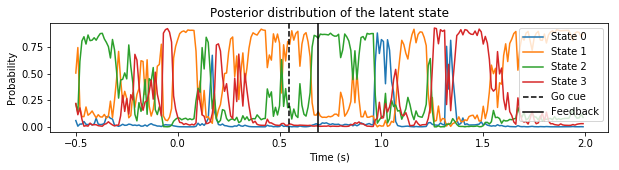

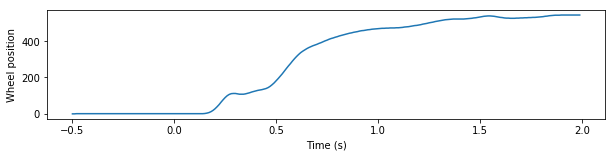

10
10
1.0
-------- Trial number 10 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward
0.5624090636191568


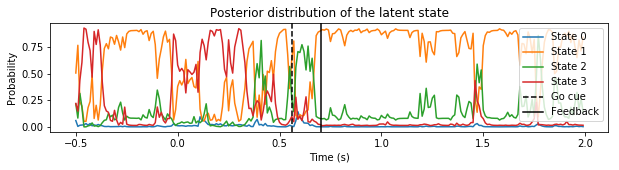

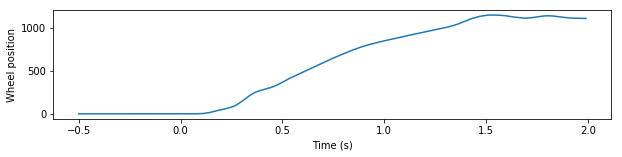

70
70
-1.0
-------- Trial number 70 --------
Stimulus: Neither
Response: Right
Feedback: White noise
0.9068146940492738


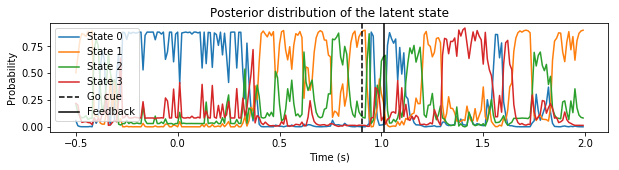

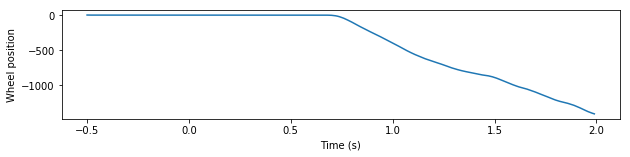

4
4
-1.0
-------- Trial number 4 --------
Stimulus: Left 25.0%
Response: Right
Feedback: White noise
0.9684157011180474


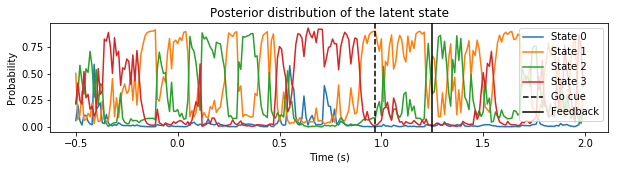

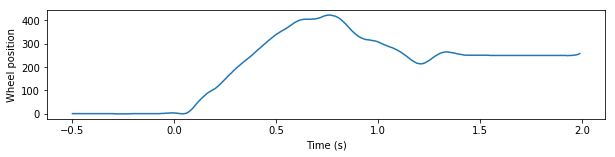

12
12
-1.0
-------- Trial number 12 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward
1.084817604085714


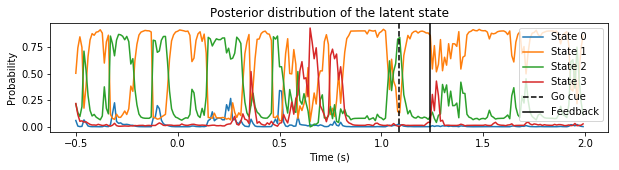

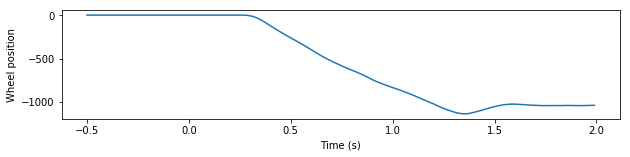

49
49
-1.0
-------- Trial number 49 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward
0.9372151910442312


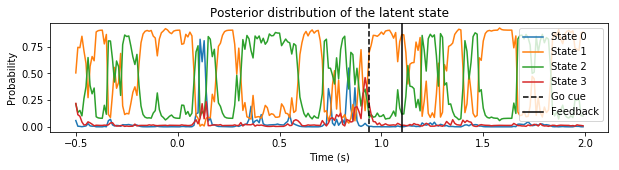

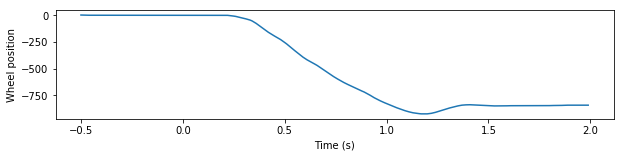

33
33
1.0
-------- Trial number 33 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: White noise
1.0352167931991687


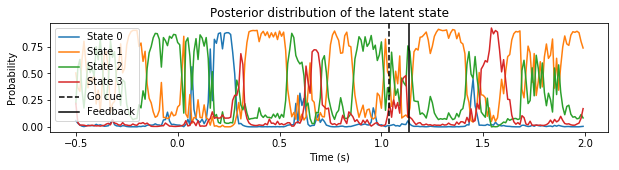

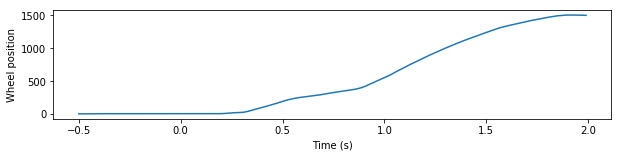

67
67
1.0
-------- Trial number 67 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward
0.6240100706880298


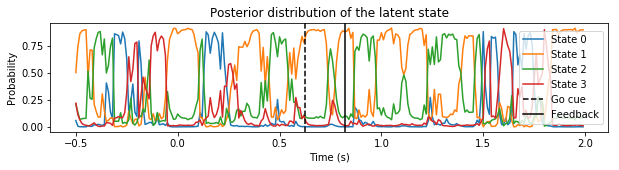

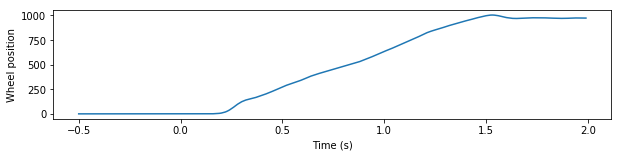

35
35
-1.0
-------- Trial number 35 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward
0.9260150079408049


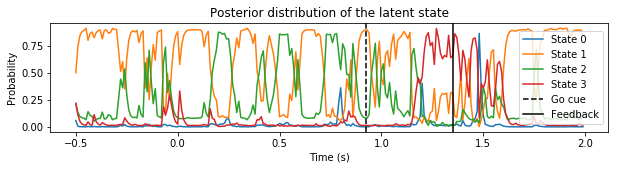

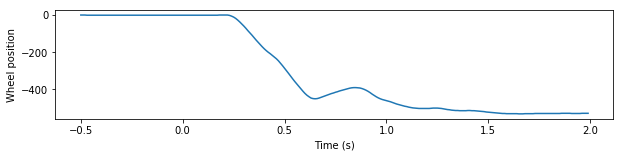

68
68
1.0
-------- Trial number 68 --------
Stimulus: Neither
Response: Left
Feedback: White noise
0.6964112543207079


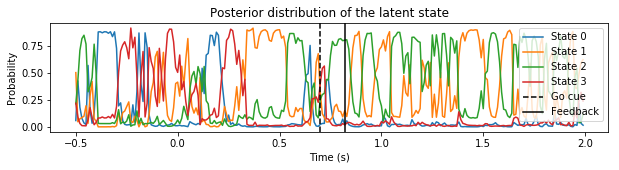

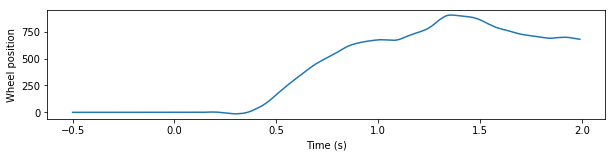

45
45
1.0
-------- Trial number 45 --------
Stimulus: Neither
Response: Left
Feedback: White noise
0.6272101230031808


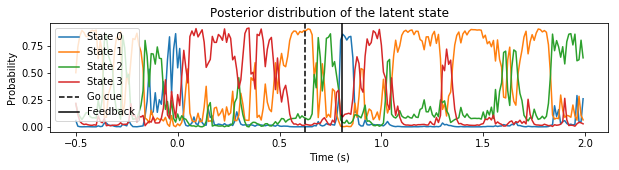

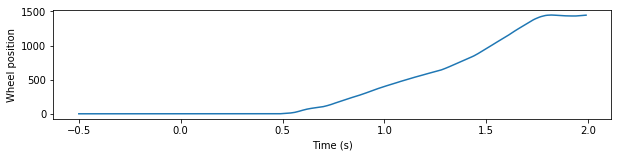

73
73
-1.0
-------- Trial number 73 --------
Stimulus: Both left: 50.0%, right: 100.0%
Response: Right
Feedback: Reward
0.8204132815371281


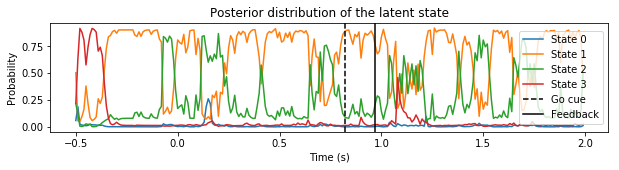

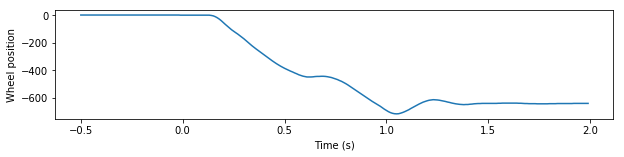

61
61
-1.0
-------- Trial number 61 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward
1.0172164989258476


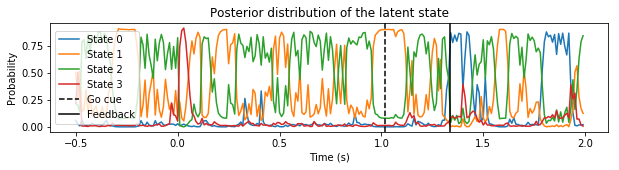

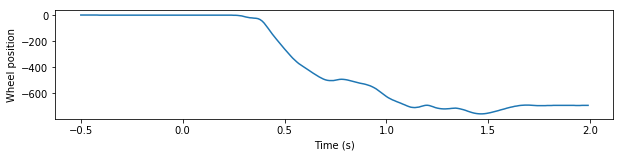

55
55
1.0
-------- Trial number 55 --------
Stimulus: Both left: 25.0%, right: 25.0%
Response: Left
Feedback: Reward
0.5260084685330071


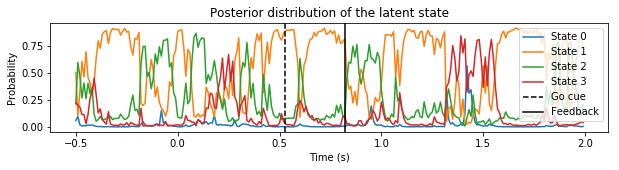

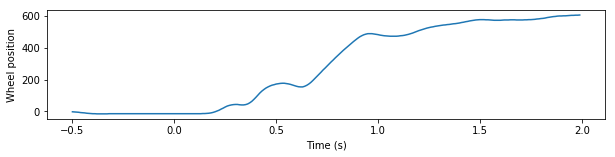

40
40
-1.0
-------- Trial number 40 --------
Stimulus: Both left: 50.0%, right: 100.0%
Response: Right
Feedback: Reward
1.0788175059946639


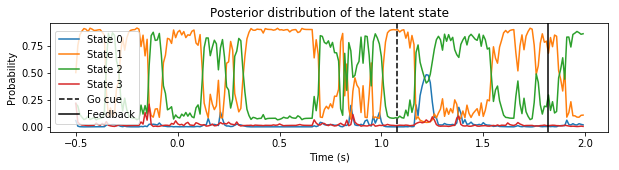

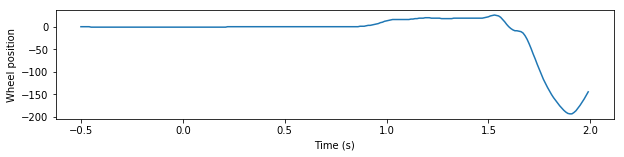

In [342]:
plot_posterior(res_mos_passive, n_trials=20, plot_wheel=True)

In [102]:
res_mos_bis = train_hmm(session, brain_area, n_states, start=0, stop=250, n_iters=0)
_, _, dat, rdm_idx, train_data, test_data = res_mos_bis

hmm, lls, _, _, _, _ = res_mos_passive

res_mos_passive_active = hmm, lls, dat, rdm_idx, train_data, test_data

(178, 250, 166)


HBox(children=(FloatProgress(value=1.0, bar_style='info', max=1.0), HTML(value='')))

-------- Trial number 19 --------
Stimulus: Neither
Response: Right
Feedback: White noise


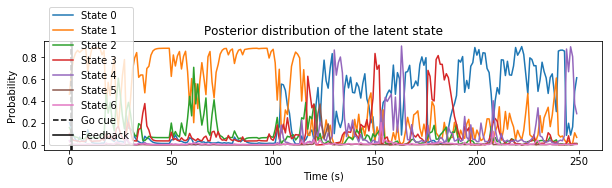

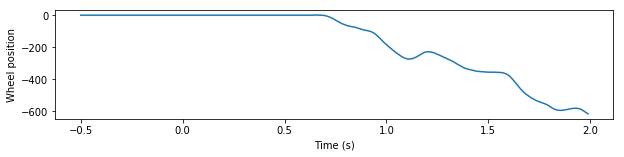

-------- Trial number 45 --------
Stimulus: Neither
Response: Left
Feedback: White noise


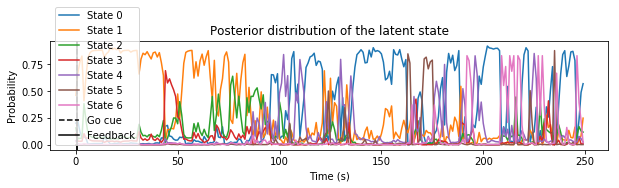

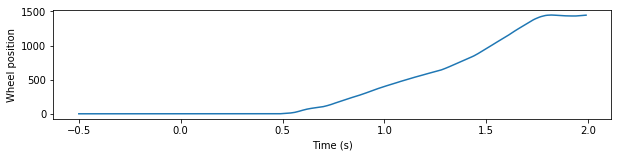

-------- Trial number 140 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


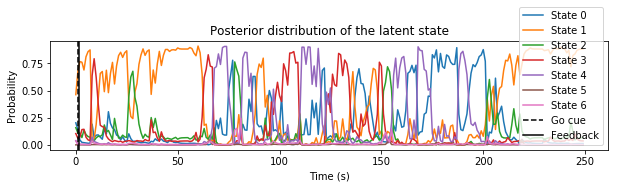

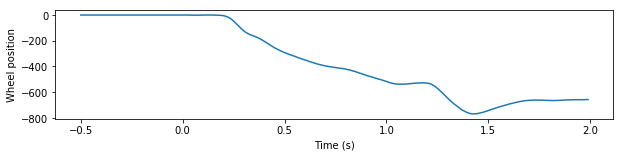

-------- Trial number 30 --------
Stimulus: Both left: 25.0%, right: 25.0%
Response: NoGo
Feedback: White noise


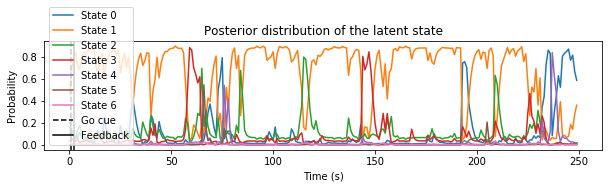

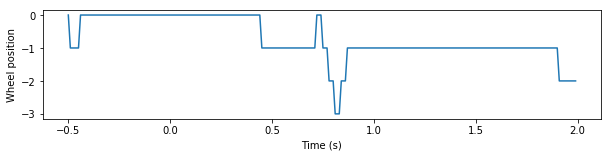

-------- Trial number 67 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


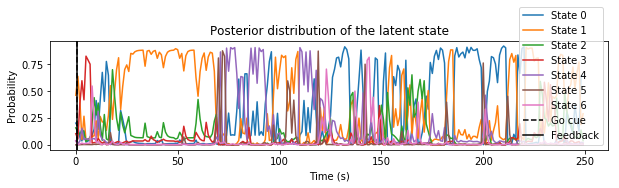

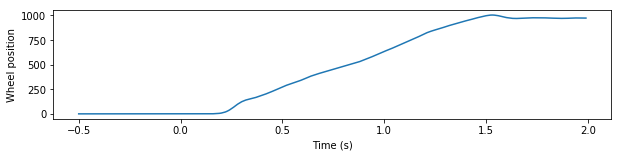

-------- Trial number 16 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Right
Feedback: Reward


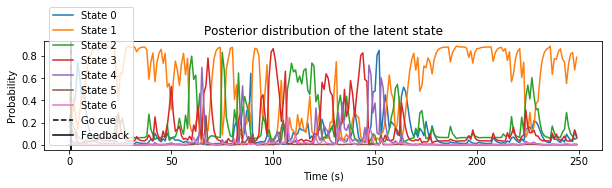

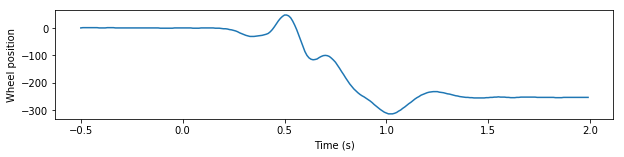

-------- Trial number 119 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


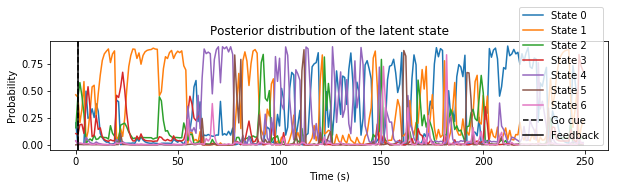

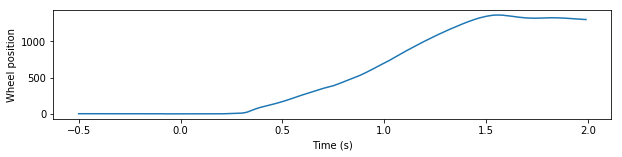

-------- Trial number 174 --------
Stimulus: Left 100.0%
Response: NoGo
Feedback: White noise


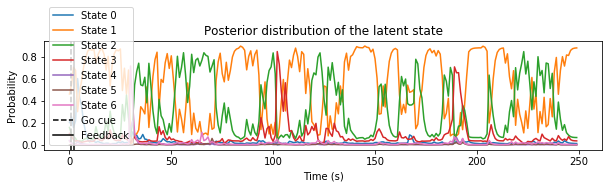

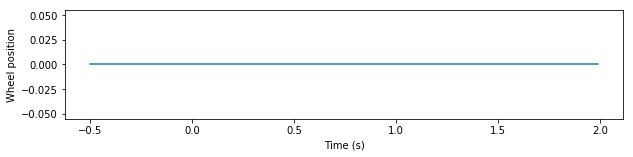

-------- Trial number 109 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


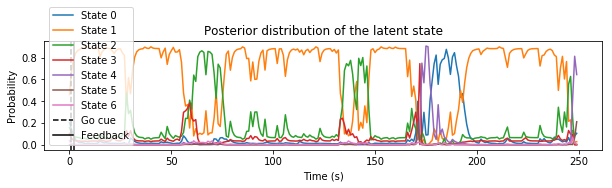

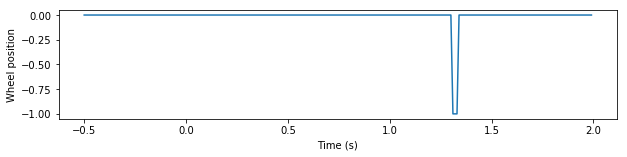

-------- Trial number 141 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


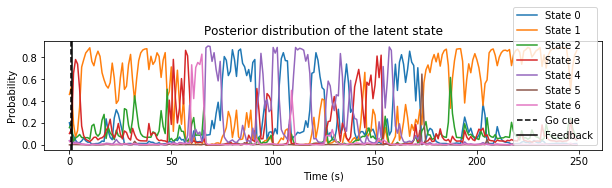

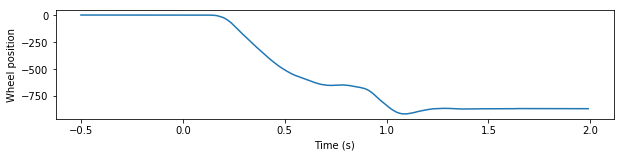

-------- Trial number 24 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


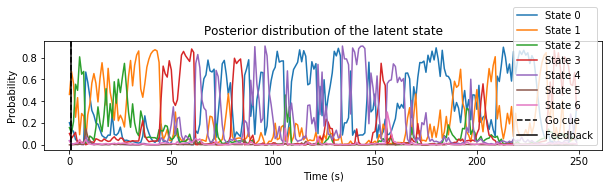

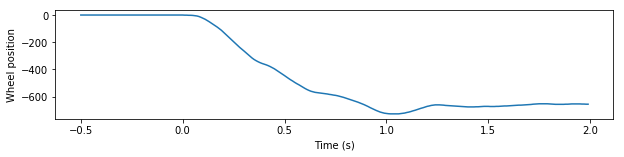

-------- Trial number 150 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


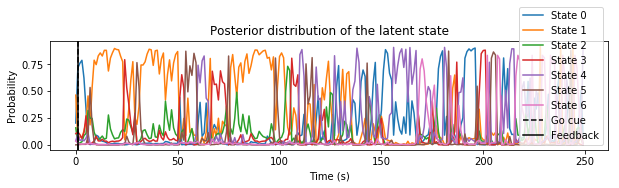

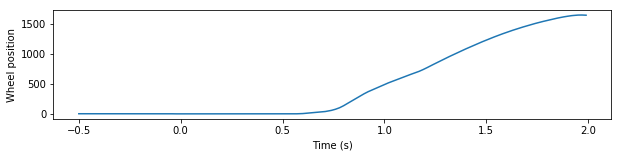

-------- Trial number 41 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


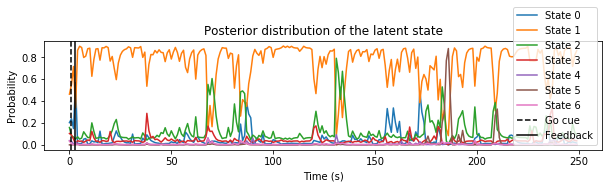

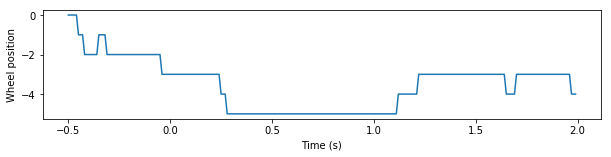

-------- Trial number 118 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


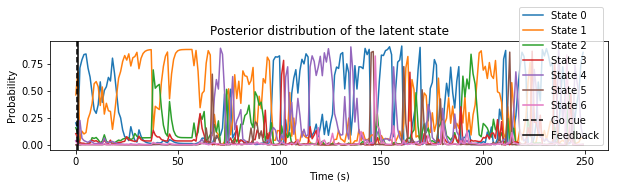

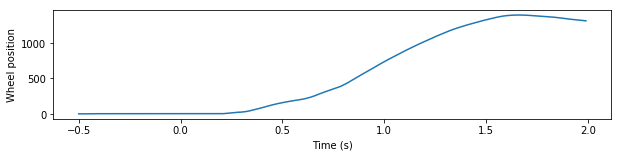

-------- Trial number 15 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


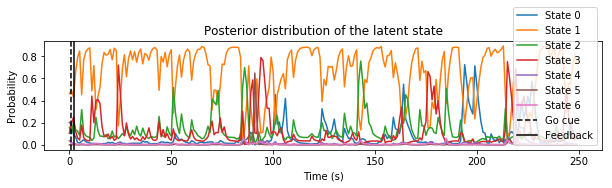

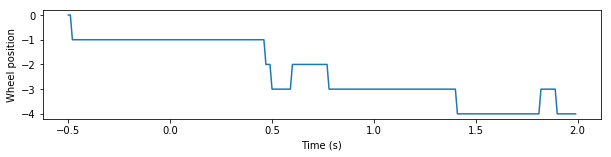

-------- Trial number 111 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


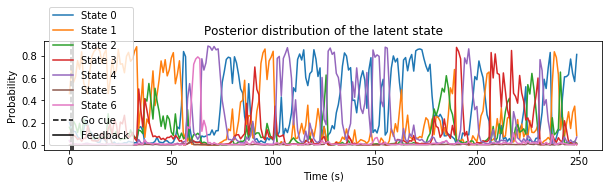

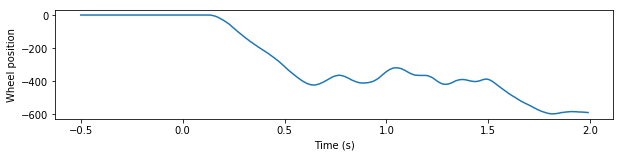

-------- Trial number 113 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


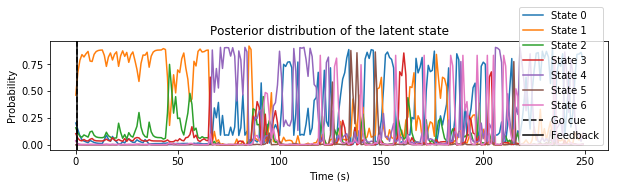

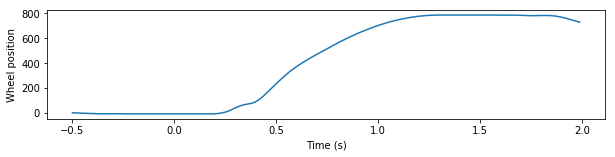

-------- Trial number 82 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


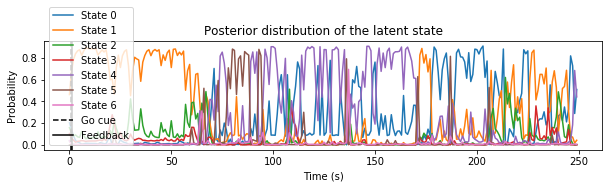

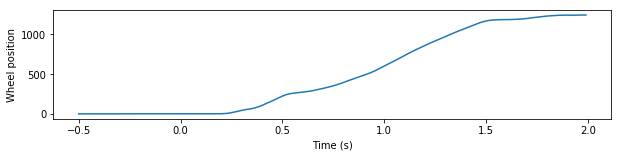

-------- Trial number 9 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


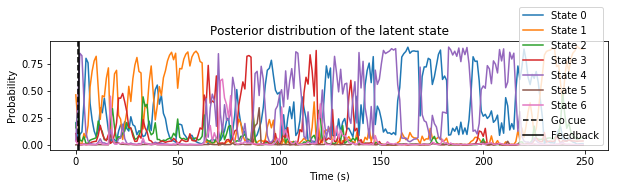

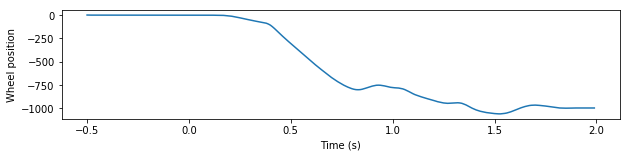

-------- Trial number 114 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


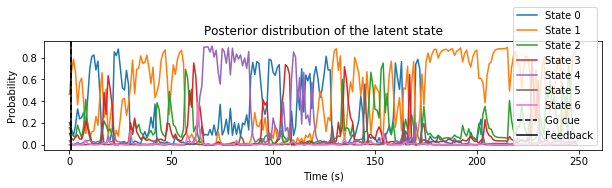

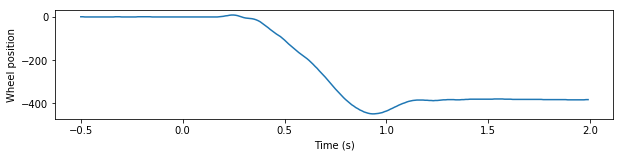

In [104]:
plot_posterior(res_mos_passive_active, n_trials=20, plot_wheel=True)

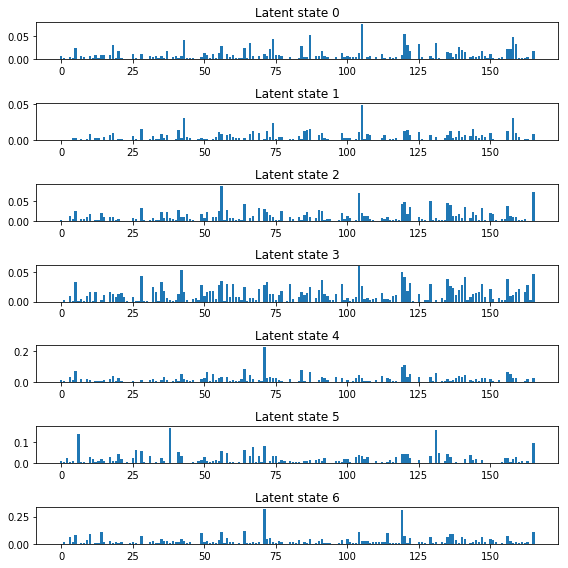

In [105]:
plot_hidden_states(res_mos_passive_active)